<a href="https://colab.research.google.com/github/ferjorosa/learn-pytorch/blob/main/FastAI%20NLP%20Course/Translation%2C%20attention%20and%20transformers/name_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating names with a character-level RNN

As stated by the title, the objective of this notebook is to learn how to generate names using a recurrent neural network (RNN).

This notebook corresponds to a modified version of the following <a href="https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html">PyTorch tutorial</a>

## 1 - Data

We have 18 files with examples from different names, grouped by country. We read each of these names and transform them into ASCII format

In [1]:
#Only on Google Colab

URL = "https://raw.githubusercontent.com/ferjorosa/learn-pytorch/main/FastAI%20NLP%20Course/Translation%2C%20attention%20and%20transformers/data_names"

!wget -r --no-parent --cut-dirs=7 {URL}/Arabic.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Chinese.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Czech.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Dutch.txt
!wget -r --no-parent --cut-dirs=7 {URL}/English.txt
!wget -r --no-parent --cut-dirs=7 {URL}/French.txt
!wget -r --no-parent --cut-dirs=7 {URL}/German.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Greek.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Irish.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Italian.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Japanese.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Korean.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Polish.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Portuguese.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Russian.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Scottish.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Spanish.txt
!wget -r --no-parent --cut-dirs=7 {URL}/Vietnamese.txt

!mv raw.githubusercontent.com data_names

--2022-03-28 15:00:09--  https://raw.githubusercontent.com/ferjorosa/learn-pytorch/main/FastAI%20NLP%20Course/Translation%2C%20attention%20and%20transformers/data_names/Arabic.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13190 (13K) [text/plain]
Saving to: ‘raw.githubusercontent.com/Arabic.txt’

raw.githubuserconte 100%[===================>]  12.88K  --.-KB/s    in 0s      

2022-03-28 15:00:09 (59.6 MB/s) - ‘raw.githubusercontent.com/Arabic.txt’ saved [13190/13190]

FINISHED --2022-03-28 15:00:09--
Total wall clock time: 0.2s
Downloaded: 1 files, 13K in 0s (59.6 MB/s)
--2022-03-28 15:00:10--  https://raw.githubusercontent.com/ferjorosa/learn-pytorch/main/FastAI%20NLP%20Course/Translation%2C%20attention%20and%20transformers/data_names/Chinese.txt
Reso

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data_names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Russian', 'Spanish', 'French', 'Greek', 'Irish', 'Japanese', 'German', 'Dutch', 'Vietnamese', 'English', 'Italian', 'Czech', 'Portuguese', 'Korean', 'Polish', 'Arabic', 'Chinese', 'Scottish']
O'Neal


In [3]:
category_lines["Arabic"][:5]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']

## 2 - Model

<img src="https://github.com/ferjorosa/learn-pytorch/blob/main/FastAI%20NLP%20Course/Translation%2C%20attention%20and%20transformers/images/name_generation_model.png?raw=1" width="600">

In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

We re going to usenegative log-likelihood loss. For that reason, we need to use `LogSoftmax` in the model

## 3- Training

### 3.1 - Setup

First of all, we need helper functions to get random pairs of (category, line)

In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [6]:
randomTrainingPair()

('Greek', 'Stamatas')

### 3.2 - Training process

For each letter in a training word, the inputs of the network will be `category`, `current_letter`, `current_hidden_state`, and the outputs will be `next_letter`, `next_hidden_state`. So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).
    
<img src="https://github.com/ferjorosa/learn-pytorch/blob/main/FastAI%20NLP%20Course/Translation%2C%20attention%20and%20transformers/images/name_generation_input_output.png?raw=1">
    
The category tensor is a one-hot tensor of size `<1 x n_categories>`. When training we feed it to the network at every timestep (i.e., training word) - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [7]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we’ll make a randomTrainingExample function that fetches a random (category, line) pair and turns them into the required `(category, input, target)` tensors.

In [8]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample(debug=False):
    
    category, line = randomTrainingPair()
    
    if debug:
        print((category, line))
    
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [9]:
randomTrainingExample(debug=True)

('German', 'Glockner')


(tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

From this, we can see that each training example will consider a number of one-hot encoded tensors for category and the training words, but also a set of target word indexes. The last index will correspond to the EOS token.

### 3.3 - Model training

In [10]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    model.train()
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

We are adding the following function to keep track of training time

In [11]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
model = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 15s (5000 5%) 2.8593
0m 30s (10000 10%) 2.9703
0m 45s (15000 15%) 3.3849
0m 59s (20000 20%) 2.5796
1m 15s (25000 25%) 2.2414
1m 30s (30000 30%) 2.3029
1m 45s (35000 35%) 3.3472
2m 1s (40000 40%) 3.0359
2m 16s (45000 45%) 3.2598
2m 30s (50000 50%) 2.5097
2m 45s (55000 55%) 2.1935
3m 1s (60000 60%) 3.0463
3m 16s (65000 65%) 2.2680
3m 31s (70000 70%) 2.1562
3m 46s (75000 75%) 2.0386
4m 1s (80000 80%) 1.9458
4m 16s (85000 85%) 2.4471
4m 31s (90000 90%) 2.6973
4m 46s (95000 95%) 2.0612
5m 1s (100000 100%) 2.0012


#### Plotting the losses

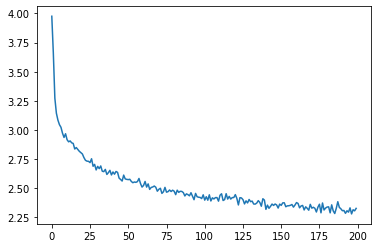

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 4 - Inference

### 4.1 - Sampling names given the category and an initial word

**Overview:**
1. Give the network a letter and ask what the next one is
2. Feed the result as the next letter
3. Repeat 1-2 unilt the EOS token

**Process**

* Create tensors for input category, starting letter, and empty hidden state
* Create a string output_name with the starting letter
* Up to a maximum output length,
    * Feed the current letter to the network
    * Get the next letter from highest output, and next hidden state
    * If the letter is EOS, stop here
    * If a regular letter, add to output_name and continue
* Return the final name

**Note:** Rather than having to give it a starting letter, another strategy would have been to include a “start of string” token in training and have the network choose its own starting letter.

In [41]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    model.eval()
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'LOL')

samples('German', 'GER')

# samples('Spanish', 'SPA')

# samples('Chinese', 'CHI')

Lantovak
Orakov
Lantovak
Gerter
Ereng
Roung


**Note:** I don't know why, but running this final inference in Google Colab gives me the same names every time. In the local machine I was getting different results...